In [9]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [10]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [11]:
df["PrevClose"] = df["close"].shift(1)
df["Return"] = (df["close"] - df["PrevClose"]) / df["PrevClose"]

In [12]:
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

In [13]:
T = 10
D = input_data.shape[1]
N = len(input_data) - T

In [14]:
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [15]:
x_train = np.zeros((Ntrain, T, D))
y_train = np.zeros((Ntrain, 1))

for t in range(Ntrain):
    x_train[t, :, :] = input_data[t:t+T]
    y_train[t] = (targets[t+T] > 0)
    

In [16]:
x_test = np.zeros((N - Ntrain, T, D))
y_test = np.zeros((N - Ntrain, 1))

for u in range(N - Ntrain):
    t = u + Ntrain
    x_test[u, :, :] = input_data[t:t+T]
    y_test[u] = (targets[t+T] > 0)

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [18]:
class SimpleRNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(SimpleRNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        
        self.rnn = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            # nonlinearity='relu',
            batch_first=True
        )
        self.fc = nn.Linear(self.M, self.K)
        
    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        # get RNN unit output
        # out is of size (N, T, M)
        out, _ = self.rnn(X, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [19]:
model = SimpleRNN(n_inputs=5, n_hidden=50, n_rnnlayers=2, n_outputs=1)
model.to(device)

SimpleRNN(
  (rnn): LSTM(5, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [20]:
criteria = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [21]:
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=200):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for it in range(epochs):
        optimizer.zero_grad()
        
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        loss.backward()
        optimizer.step()
        
        train_losses[it] = loss.item()
        
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()
        
        if (it + 1) % 5 == 0:
            print(f'Epoch {it + 1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
    
    return train_losses, test_losses

In [23]:
x_train = torch.from_numpy(x_train[:-N//2].astype(np.float32)).to(device)
y_train = torch.from_numpy(y_train[:-N//2].astype(np.float32)).to(device)
x_test = torch.from_numpy(x_test[-N//2:].astype(np.float32)).to(device)
y_test = torch.from_numpy(y_test[-N//2:].astype(np.float32)).to(device)

In [24]:
train_losses, test_losses = full_gd(model, criteria, optimizer, x_train, y_train, x_test, y_test)

Epoch 5/200, Train Loss: 0.6899, Test Loss: 0.6967
Epoch 10/200, Train Loss: 0.6861, Test Loss: 0.7259
Epoch 15/200, Train Loss: 0.6839, Test Loss: 0.7156
Epoch 20/200, Train Loss: 0.6766, Test Loss: 0.7128
Epoch 25/200, Train Loss: 0.6770, Test Loss: 0.6981
Epoch 30/200, Train Loss: 0.6614, Test Loss: 0.7480
Epoch 35/200, Train Loss: 0.6421, Test Loss: 0.8648
Epoch 40/200, Train Loss: 0.6394, Test Loss: 0.9650
Epoch 45/200, Train Loss: 0.6012, Test Loss: 0.9777
Epoch 50/200, Train Loss: 0.5650, Test Loss: 1.0423
Epoch 55/200, Train Loss: 0.5272, Test Loss: 1.0987
Epoch 60/200, Train Loss: 0.4802, Test Loss: 1.0847
Epoch 65/200, Train Loss: 0.5595, Test Loss: 1.1534
Epoch 70/200, Train Loss: 0.4788, Test Loss: 0.9720
Epoch 75/200, Train Loss: 0.3892, Test Loss: 1.3587
Epoch 80/200, Train Loss: 0.3374, Test Loss: 1.3208
Epoch 85/200, Train Loss: 0.2650, Test Loss: 1.4930
Epoch 90/200, Train Loss: 0.2127, Test Loss: 1.7715
Epoch 95/200, Train Loss: 0.1192, Test Loss: 1.9600
Epoch 100/200

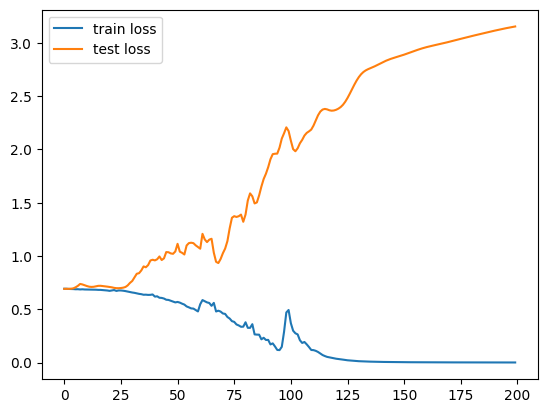

In [25]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [26]:
with torch.no_grad():
    p_train = model(x_train)
    p_train = (p_train.cpu().numpy() > 0)
    train_acc = np.mean(y_train.cpu().numpy() == p_train)
    
    p_test = model(x_test)
    p_test = (p_test.cpu().numpy() > 0)
    test_acc = np.mean(y_test.cpu().numpy() == p_test)
    
print(f'Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}')

Train acc: 1.0000, Test acc: 0.5073
